#**Preprocessing Images Apple Dataset**

In [1]:
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
import pytz
from time import time

import openpyxl
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.styles import Font, Alignment
import os
import sys

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from matplotlib import font_manager
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import psutil
import zipfile


import numpy as np
import tensorflow as tf
import random as rd

**Detail of Python Notebook in Google Colab**

In [ ]:
!nvidia-smi
import subprocess
print(f"Tensorflow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")
print("-------------------------------------------------------------")
print(f"Python {sys.version}")
print("-------------------------------------------------------------")

# ตรวจสอบ GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("Running on GPU")
    strategy = tf.distribute.MirroredStrategy()
    print(f"Number of GPUs Available: {len(gpus)}")

    # ดึงข้อมูล GPU Memory
    try:
        result = subprocess.run(
            ['nvidia-smi', '--query-gpu=memory.total', '--format=csv,noheader,nounits'],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True
        )
        gpu_memory = result.stdout.strip().split('\n')
        for idx, mem in enumerate(gpu_memory):
            print(f"GPU {idx}: Total Memory: {int(mem) / 1024:.2f} GB")
    except FileNotFoundError:
        print("nvidia-smi is not available on this system.")
else:
    print("No GPU detected. Running on CPU")
    strategy = tf.distribute.get_strategy()

# แสดงจำนวนอุปกรณ์ที่พร้อมใช้งาน
print("Number of replicas:", strategy.num_replicas_in_sync)
print("-------------------------------------------------------------")

# แสดงจำนวน RAM ทั้งหมด
total_ram = psutil.virtual_memory().total / (1024 ** 3)
print(f"Total RAM of Colab instance: {total_ram:.2f} GB")
print("-------------------------------------------------------------")

# แสดงเวลาปัจจุบันในเขตเวลาไทย
thailand_tz = pytz.timezone('Asia/Bangkok')
current_time = datetime.now(thailand_tz).strftime("%Y-%m-%d %H:%M:%S")
print("Current Time (Thailand):", current_time)

Sun Aug 24 13:16:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
from google.colab import drive
drive.mount('/content/drive')

sys.path.append('/content/drive/MyDrive/projectPlant/Colab')
from my_model import *
from helper_functions import *

Mounted at /content/drive


**Initialize Setting**

In [4]:
root_dir = '/content/drive/MyDrive/projectPlant/'

**SEED**

In [5]:
seeds = [42]
print(seeds)

[42]


**Font Setting**

In [6]:
locations = [f"{root_dir}Extra2/Font"]
font_files = font_manager.findSystemFonts(fontpaths=locations)
print(font_files[0])
for file in font_files:
  font_manager.fontManager.addfont(file)

/content/drive/MyDrive/projectPlant/Extra2/Font/OPTITimes-Roman.otf


**คำอธิบาย**

แบ่ง Data แบบ Fixed Train Validation และ Test ในอัตราส่วน 64:16:20

In [7]:
apple_title = 'Apple Dataset'
apple_dataset_name = 'appleDataset'
apple_dataset_dir = root_dir + apple_dataset_name

In [ ]:
zip_filename = 'apple_dataset_raw.zip'
zip_dir = apple_dataset_dir + '/' + zip_filename
target_folders = [apple_dataset_dir]
with zipfile.ZipFile(zip_dir, "w", zipfile.ZIP_DEFLATED) as zipf:
    for folder in target_folders:
        for root, dirs, files in os.walk(folder):
            for file in files:
                file_path = os.path.join(root, file)
                zipf.write(file_path, os.path.relpath(file_path, os.path.dirname(folder)))
print(f'Zip folder complete at {zip_dir}')

Zip folder complete at /content/drive/MyDrive/projectPlant/appleDataset/apple_dataset_raw.zip


In [8]:
apple_img_dir = root_dir + 'Extra2/' + apple_dataset_name
apple_sample_img_dir = apple_img_dir + '/SampleImages'
apple_excel_dir = root_dir + 'DatasetSetting/' + apple_dataset_name + '/'

os.makedirs(apple_img_dir, exist_ok=True)
os.makedirs(apple_sample_img_dir, exist_ok=True)
os.makedirs(apple_excel_dir, exist_ok=True)

**Recheck Path and Verify Images**

In [ ]:
print("Total directories and apple dataset images: \n")
walk_through_dir(apple_dataset_dir)

Total directories and apple dataset images: 

There are 4 directories and 0 images in '/content/drive/MyDrive/projectPlant/appleDataset'.
There are 0 directories and 516 images in '/content/drive/MyDrive/projectPlant/appleDataset/healthy'.
There are 0 directories and 592 images in '/content/drive/MyDrive/projectPlant/appleDataset/scab'.
There are 0 directories and 91 images in '/content/drive/MyDrive/projectPlant/appleDataset/multiple_disease'.
There are 0 directories and 622 images in '/content/drive/MyDrive/projectPlant/appleDataset/rust'.


In [ ]:
print("Verifying apple dataset images: \n")
verify_images(apple_dataset_dir)

Verifying apple dataset images: 

Checking: /content/drive/MyDrive/projectPlant/appleDataset/healthy/Train_989.jpg Done
Checking: /content/drive/MyDrive/projectPlant/appleDataset/healthy/Train_979.jpg Done
Checking: /content/drive/MyDrive/projectPlant/appleDataset/healthy/Train_981.jpg Done
Checking: /content/drive/MyDrive/projectPlant/appleDataset/healthy/Train_983.jpg Done
Checking: /content/drive/MyDrive/projectPlant/appleDataset/healthy/Train_99.jpg Done
Checking: /content/drive/MyDrive/projectPlant/appleDataset/healthy/Train_961.jpg Done
Checking: /content/drive/MyDrive/projectPlant/appleDataset/healthy/Train_959.jpg Done
Checking: /content/drive/MyDrive/projectPlant/appleDataset/healthy/Train_960.jpg Done
Checking: /content/drive/MyDrive/projectPlant/appleDataset/healthy/Train_968.jpg Done
Checking: /content/drive/MyDrive/projectPlant/appleDataset/healthy/Train_977.jpg Done
Checking: /content/drive/MyDrive/projectPlant/appleDataset/healthy/Train_953.jpg Done
Checking: /content/dr

**Convert to dataframe**

In [9]:
base_apple_df = to_dataframe(apple_dataset_dir, mode='single', condition=False, labels_mapping=None)

Total images: 1821
Total classes: 4


In [ ]:
print("Base Apple Dataframe \n")
base_apple_df

Base Apple Dataframe 



,Filepath,Label
0,/content/drive/MyDrive/projectPlant/appleDatas...,healthy
1,/content/drive/MyDrive/projectPlant/appleDatas...,healthy
2,/content/drive/MyDrive/projectPlant/appleDatas...,healthy
3,/content/drive/MyDrive/projectPlant/appleDatas...,healthy
4,/content/drive/MyDrive/projectPlant/appleDatas...,healthy
...,...,...
1816,/content/drive/MyDrive/projectPlant/appleDatas...,rust
1817,/content/drive/MyDrive/projectPlant/appleDatas...,rust
1818,/content/drive/MyDrive/projectPlant/appleDatas...,rust
1819,/content/drive/MyDrive/projectPlant/appleDatas...,rust


**Description table**

In [ ]:
print(f"{apple_title} description table \n")
apple_summary_df = base_apple_df.groupby('Label').size().reset_index(name='Count')
apple_summary_df

Apple Dataset description table 



,Label,Count
0,healthy,516
1,multiple_disease,91
2,rust,622
3,scab,592


##**Visualize Images**

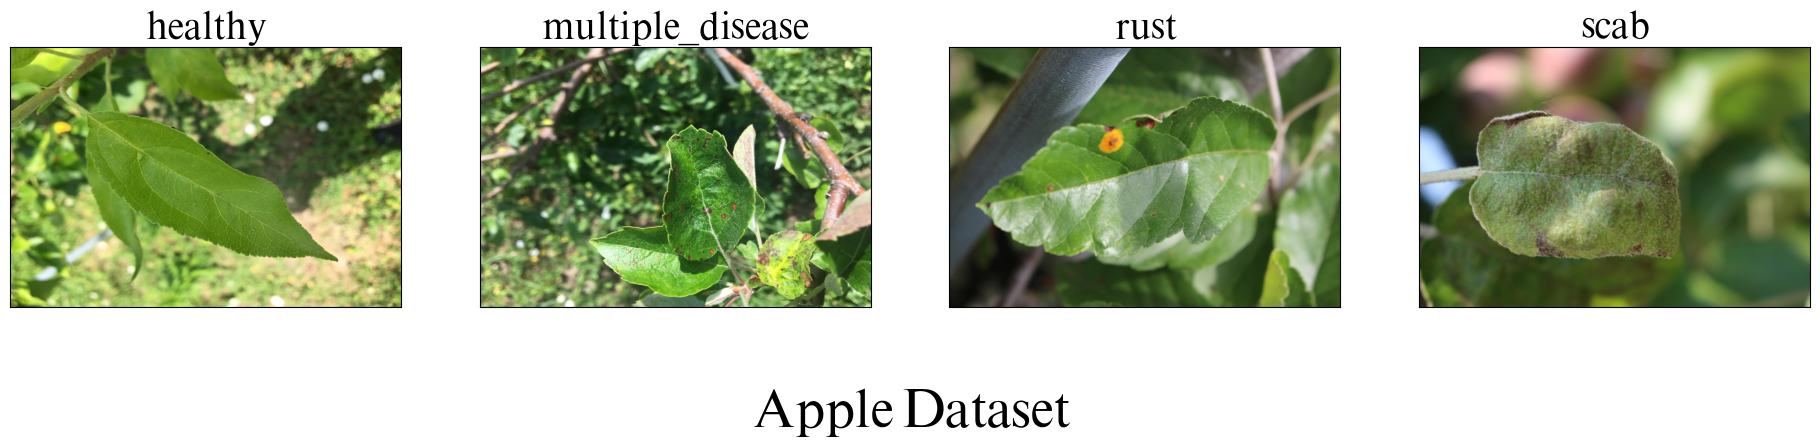

In [10]:
visualize_images_by_class(df=base_apple_df, nrows=1, ncols=4, title=apple_title, fontsize=25,
                          fontname="OPTITimes-Roman", image_width=5, image_height=5, paths=apple_sample_img_dir)

##**Allocate Dataset**

In [ ]:
# วนลูปสำหรับแต่ละ SEED
for seed in seeds:
    print(f"Running experiment with SEED={seed}")
    np.random.seed(seed)

    # แบ่งข้อมูล Train (80%) และ Test (20%)
    train_data, test_data = train_test_split(
        base_apple_df,
        test_size=0.2,
        random_state=seed,
        stratify=base_apple_df['Label']
    )

    # แบ่งข้อมูล Train (64%) และ Validation (16%) จาก Train (80%)
    train_data, val_data = train_test_split(
        train_data,
        test_size=0.2,  # 20% ของ 80% = 16%
        random_state=seed,
        stratify=train_data['Label']
    )

    # เก็บ Original_Index
    train_data['Original_Index'] = train_data.index
    val_data['Original_Index'] = val_data.index
    test_data['Original_Index'] = test_data.index

    # สร้าง DataFrame สำหรับ Train, Validation, Test
    data = {
        'Train_Index': train_data['Original_Index'].tolist(),
        'Train_Paths': train_data['Filepath'].tolist(),
        'Validation_Index': val_data['Original_Index'].tolist(),
        'Validation_Paths': val_data['Filepath'].tolist(),
        'Test_Index': test_data['Original_Index'].tolist(),
        'Test_Paths': test_data['Filepath'].tolist(),
    }

    # เติมข้อมูลให้มีความยาวเท่ากัน
    max_length = max(
        len(data['Train_Paths']),
        len(data['Validation_Paths']),
        len(data['Test_Paths'])
    )

    data['Train_Index'] += [''] * (max_length - len(data['Train_Index']))
    data['Train_Paths'] += [''] * (max_length - len(data['Train_Paths']))
    data['Validation_Index'] += [''] * (max_length - len(data['Validation_Index']))
    data['Validation_Paths'] += [''] * (max_length - len(data['Validation_Paths']))
    data['Test_Index'] += [''] * (max_length - len(data['Test_Index']))
    data['Test_Paths'] += [''] * (max_length - len(data['Test_Paths']))

    # แปลงข้อมูลเป็น DataFrame
    df = pd.DataFrame(data)

    # ตั้งชื่อไฟล์ที่บันทึก
    file_name = f'{apple_excel_dir}split_data_seed_{seed}.xlsx'

    # บันทึกข้อมูลลง Excel
    with pd.ExcelWriter(file_name, engine='openpyxl') as writer:
        df.to_excel(writer, index=False, sheet_name='Split-Data')

        # ปรับขนาดคอลัมน์
        workbook = writer.book
        sheet = workbook['Split-Data']

        for col in sheet.columns:
            max_length = 0
            column = col[0].column_letter  # Get the column letter
            for cell in col:
                try:
                    if len(str(cell.value)) > max_length:
                        max_length = len(str(cell.value))
                except:
                    pass
            adjusted_width = max_length + 2
            sheet.column_dimensions[column].width = adjusted_width

        # จัดรูปแบบ header
        header = sheet[1]
        for cell in header:
            cell.alignment = Alignment(horizontal="center", vertical="center")
            cell.font = Font(bold=True)

    print(f"Data split and saved to {file_name}")
    print("--------------------------------------------------")

Running experiment with SEED=42
Data split and saved to /content/drive/MyDrive/projectPlant/DatasetSetting/appleDataset/split_data_seed_42.xlsx
--------------------------------------------------


##**Augmentation Samples Images**

In [ ]:
train_data

,Filepath,Label,Original_Index
352,/content/drive/MyDrive/projectPlant/appleDatas...,healthy,352
612,/content/drive/MyDrive/projectPlant/appleDatas...,scab,612
1214,/content/drive/MyDrive/projectPlant/appleDatas...,rust,1214
1350,/content/drive/MyDrive/projectPlant/appleDatas...,rust,1350
1474,/content/drive/MyDrive/projectPlant/appleDatas...,rust,1474
...,...,...,...
216,/content/drive/MyDrive/projectPlant/appleDatas...,healthy,216
995,/content/drive/MyDrive/projectPlant/appleDatas...,scab,995
33,/content/drive/MyDrive/projectPlant/appleDatas...,healthy,33
1218,/content/drive/MyDrive/projectPlant/appleDatas...,rust,1218


In [ ]:
val_data

,Filepath,Label,Original_Index
406,/content/drive/MyDrive/projectPlant/appleDatas...,healthy,406
262,/content/drive/MyDrive/projectPlant/appleDatas...,healthy,262
1460,/content/drive/MyDrive/projectPlant/appleDatas...,rust,1460
377,/content/drive/MyDrive/projectPlant/appleDatas...,healthy,377
629,/content/drive/MyDrive/projectPlant/appleDatas...,scab,629
...,...,...,...
110,/content/drive/MyDrive/projectPlant/appleDatas...,healthy,110
57,/content/drive/MyDrive/projectPlant/appleDatas...,healthy,57
1179,/content/drive/MyDrive/projectPlant/appleDatas...,multiple_disease,1179
692,/content/drive/MyDrive/projectPlant/appleDatas...,scab,692


In [ ]:
SEED=seeds[-1]
np.random.seed(SEED)
tf.random.set_seed(SEED)
rd.seed(SEED)

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest'
)

train_images = train_generator.flow_from_dataframe(
    dataframe = train_data,
    x_col = 'Filepath',
    y_col = 'Label',
    target_size = IMAGE_SIZE,
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = SEED
)

Found 1164 validated image filenames belonging to 4 classes.


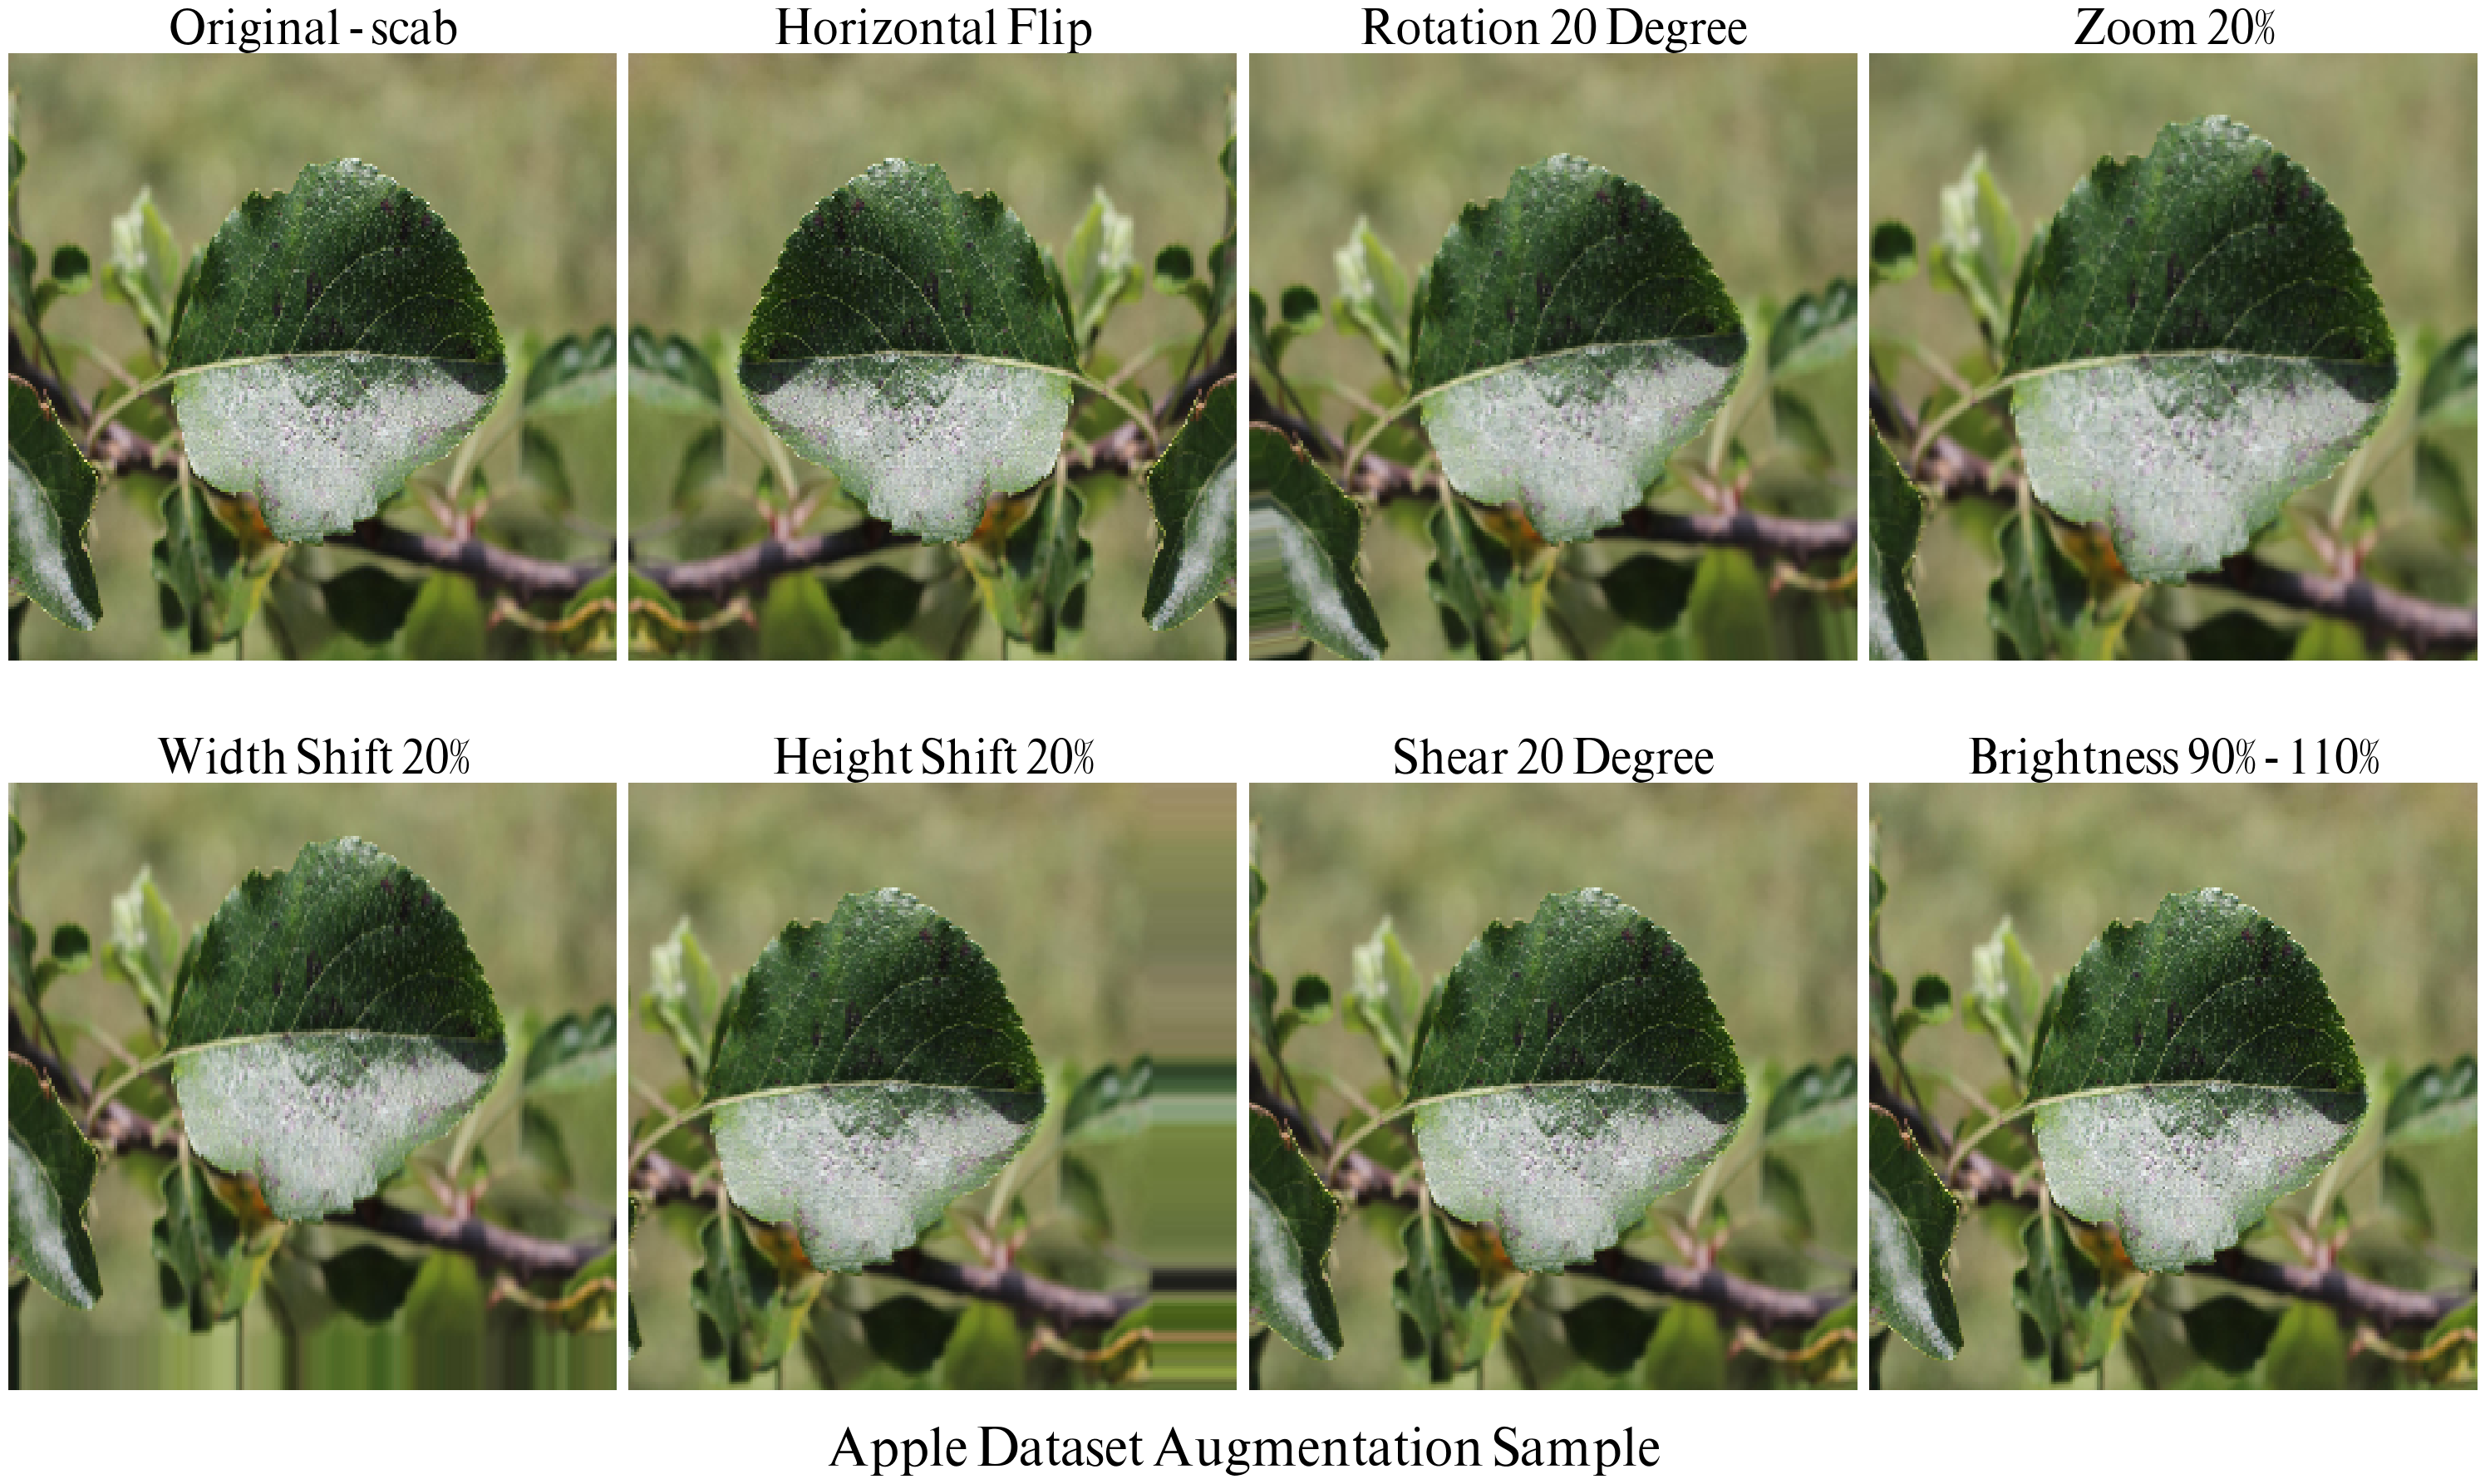

In [ ]:
preview_augmented_images(train_data, title=apple_title, index=15, paths=apple_sample_img_dir)

## **Summary of dataset**

**ส่วนที่รันเพิ่มเติม**

In [ ]:
TRAIN_DF, VALID_DF, TEST_DF = to_dataframe_excel(path="/content/drive/MyDrive/projectPlant/DatasetSetting/appleDataset/split_data_seed_42.xlsx", sheet_name='Split-Data', mode='single', condition=False, labels_mapping=None)

In [ ]:
combined_df = pd.concat([TRAIN_DF, VALID_DF, TEST_DF], axis=0).reset_index(drop=True)
combined_df = combined_df.drop(columns=['Original_Index'])
combined_df

,Filepath,Label
0,/content/drive/MyDrive/projectPlant/appleDatas...,healthy
1,/content/drive/MyDrive/projectPlant/appleDatas...,scab
2,/content/drive/MyDrive/projectPlant/appleDatas...,rust
3,/content/drive/MyDrive/projectPlant/appleDatas...,rust
4,/content/drive/MyDrive/projectPlant/appleDatas...,rust
...,...,...
1816,/content/drive/MyDrive/projectPlant/appleDatas...,rust
1817,/content/drive/MyDrive/projectPlant/appleDatas...,healthy
1818,/content/drive/MyDrive/projectPlant/appleDatas...,healthy
1819,/content/drive/MyDrive/projectPlant/appleDatas...,multiple_disease


In [ ]:
class_list = combined_df['Label'].unique().tolist()
print(class_list)

total_count = []
train_count = []
val_count = []
test_count = []

for class_name in class_list:
    total_count.append(len(combined_df[combined_df['Label'] == class_name]))
    train_count.append(len(TRAIN_DF[TRAIN_DF['Label'] == class_name]))
    val_count.append(len(VALID_DF[VALID_DF['Label'] == class_name]))
    test_count.append(len(TEST_DF[TEST_DF['Label'] == class_name]))

['healthy', 'scab', 'rust', 'multiple_disease']


In [ ]:
summary_df = pd.DataFrame({
    'Class': class_list,
    'Dataset Count': total_count,
    'Train Count': train_count,
    'Validation Count': val_count,
    'Test Count': test_count
})
print(summary_df.to_string(index=False))

           Class  Dataset Count  Train Count  Validation Count  Test Count
         healthy            516          330                83         103
            scab            592          378                95         119
            rust            622          397               100         125
multiple_disease             91           59                14          18


In [ ]:
summary_df.to_excel(apple_excel_dir + 'summary_dataset.xlsx', index=False)